In [1]:
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip "/content/drive/MyDrive/ADL-2/Dataset.zip" -d "./"

Streaming output truncated to the last 5000 lines.
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10007.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10008.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10009.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10010.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10011.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10012.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10013.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10014.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10015.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr_goo_0/10016.jpg  
  inflating: ./Dataset/smile/youtube_smile_response_smile_h_nm_np1_fr

In [4]:
os_listdir = os.listdir()

In [5]:
files = next( os.walk(os.path.join(os.getcwd(),os_listdir[os_listdir.index('Dataset')])))
files

('/content/Dataset',
 ['eat',
  'laugh',
  'somersault',
  'smile',
  'dive',
  'catch',
  'clap',
  'cartwheel',
  'climb',
  'drink'],
 [])

In [6]:
classes = files[1] 

In [7]:
class_ids = {name:id for id,name in enumerate(classes)}
class_ids

{'cartwheel': 7,
 'catch': 5,
 'clap': 6,
 'climb': 8,
 'dive': 4,
 'drink': 9,
 'eat': 0,
 'laugh': 1,
 'smile': 3,
 'somersault': 2}

In [8]:
## image frames in the video dataset: max = 85 , min = 7
videos = []
labels = []
for class_ in classes:
  print(os.path.join(files[0],class_))
  for i in os.walk(os.path.join(files[0],class_)):
    if len(i[-1]) == 0: # gives the list of videos under the path
      for video_path in i[1]:
        videos.append(files[0]+'/'+class_+'/'+video_path)
        labels.append(class_ids[class_])
print(len(videos))
assert len(videos) == len(labels)

/content/Dataset/eat
/content/Dataset/laugh
/content/Dataset/somersault
/content/Dataset/smile
/content/Dataset/dive
/content/Dataset/catch
/content/Dataset/clap
/content/Dataset/cartwheel
/content/Dataset/climb
/content/Dataset/drink
1203


In [9]:
import pandas as pd

df = pd.DataFrame({'video_name':videos,'gold_label':labels})
df.to_csv('data.csv')

In [10]:
import pandas as pd

df = pd.read_csv('/content/data.csv')

In [11]:
# temp = [len(glob.glob(df['video_name'][idx]+"/*.jpg")) for idx in range(842)]
# print(max(temp),min(temp))
import glob
[df['video_name'][idx]+"/*.jpg" for idx in range(len(df)) if len(glob.glob(df['video_name'][idx]+"/*.jpg"))<=6]  # all videos have frames >= 7

[]

In [12]:
from torch.utils.data import Dataset, DataLoader
import glob
from PIL import Image
from torchvision import transforms,models

class VideoDataset(Dataset):
    def __init__(self, df, transform):      
        self.transform = transform
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path2imgs=glob.glob(self.data['video_name'][idx]+"/*.jpg")
        timesteps = 7
        step = len(path2imgs)//timesteps
        # path2imgs = path2imgs[:timesteps]
        label = self.data['gold_label'][idx]
        frames = []
        for p2i in range(0,len(path2imgs),step):
            frame = Image.open(path2imgs[p2i])
            frames.append(frame)
            if len(frames) == timesteps:
              break
        
        # seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label  # shape = [number of frames , c, h, w]


transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
custom_dataset = VideoDataset(df, transform)
BATCH_SIZE = 4
train_loader = DataLoader(dataset=custom_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [13]:
from torch import nn

class Vgg19Rnn(nn.Module):
    def __init__(self, params_model):
        super(Vgg19Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dr_rate= params_model["dr_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        self.baseModel = models.vgg19(pretrained=pretrained)

        # disect the network to access its last convolutional layer
        self.features_conv = self.baseModel.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        num_features = self.baseModel.classifier[0].in_features # 512*7*7 = 25088

        # placeholder for the gradients
        self.gradients = None

        self.dropout= nn.Dropout(dr_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append(grad)
        
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):  # x --> [b_z, 3, 224, 224]
      x = self.features_conv(x)
      return  x  #[b_z, 512, 14, 14]

    def forward(self, x):
        b_z, ts, c, h, w = x.shape
        ii = 0     # frame number 
        #print(b_z,ts,c,h,w)
        self.gradients = []
        y = self.get_activations(x[:,ii])

        # print(f'before hook : {y.shape}') # [b_z, 512, 14, 14]

        # register the hook
        h = y.register_hook(self.activations_hook)

        y = self.max_pool(y)
        
        #print(f'after fc: {y.shape}')  # [b_z, 512, 7, 7]

        y = y.view(b_z,-1)
        # print(f"output shape : {y.shape}") # [4, 25088]
        output , (hn, cn) = self.rnn(y.unsqueeze(0))
        # print(f"output shape : {out.shape}") # [1, 4, 128]

        for ii in range(1, ts):
            y = self.get_activations(x[:,ii])

            # y.shape =  [b_z, 512, 14, 14]

            # register the hook
            h = y.register_hook(self.activations_hook)

            y = self.max_pool(y)

            y = y.view(b_z,-1)
            out, (hn, cn) = self.rnn(y.unsqueeze(0), (hn, cn))
            output = torch.cat([output,out],dim=0)

        #out = self.dropout(out.squeeze(0))
        out = self.fc1(out.squeeze(0)) 
        return out , torch.mean(output,dim = 0)  # [b_z, hid_dim]


'''
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (19): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (20): ReLU(inplace=True)
    (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace=True)
    (25): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (26): ReLU(inplace=True)
    (27): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (29): ReLU(inplace=True)
    (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (31): ReLU(inplace=True)
    (32): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (33): ReLU(inplace=True)
    (34): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (35): ReLU(inplace=True)
    (36): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
params = {"num_classes":max(df['gold_label'])+1 , "pretrained":True, 'rnn_hidden_size':128, 'dr_rate':0.1, 'rnn_num_layers':1, 'bidirectional':False}
model = Vgg19Rnn(params).to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# learning_rate = 5e-4
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

156580146

In [ ]:
num_epochs = 20

# model.train()
for epoch in range(num_epochs):
  tot_loss = 0
  acc = 0
  for i, (x,y) in enumerate(train_loader):
    # print(x.shape,y.shape)
    x = x.to(device)
    y = y.to(device)
    out = model(x)
    acc += torch.sum(torch.argmax(out,dim=-1) == y).item()
    loss = criterion(out,y)
    tot_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch : {epoch+11} | train loss: {tot_loss/((len(train_loader)-1)*BATCH_SIZE+y.shape[0]):0.4f} | train acc : {acc/((len(train_loader)-1)*BATCH_SIZE+y.shape[0]):0.4f}')


Epoch : 1 | train loss: 0.5774 | train acc : 0.1264
Epoch : 2 | train loss: 0.5710 | train acc : 0.1538
Epoch : 3 | train loss: 0.5600 | train acc : 0.1812
Epoch : 4 | train loss: 0.5490 | train acc : 0.2037
Epoch : 5 | train loss: 0.5413 | train acc : 0.2261
Epoch : 6 | train loss: 0.5345 | train acc : 0.2535
Epoch : 7 | train loss: 0.5293 | train acc : 0.2627
Epoch : 8 | train loss: 0.5248 | train acc : 0.2627
Epoch : 9 | train loss: 0.5202 | train acc : 0.2751
Epoch : 10 | train loss: 0.5167 | train acc : 0.2818
Epoch : 11 | train loss: 0.5132 | train acc : 0.2893
Epoch : 12 | train loss: 0.5103 | train acc : 0.2884
Epoch : 13 | train loss: 0.5075 | train acc : 0.2968
Epoch : 14 | train loss: 0.5053 | train acc : 0.2843
Epoch : 15 | train loss: 0.5026 | train acc : 0.2968
Epoch : 16 | train loss: 0.5005 | train acc : 0.3034
Epoch : 17 | train loss: 0.4984 | train acc : 0.3067
Epoch : 18 | train loss: 0.4963 | train acc : 0.3092
Epoch : 19 | train loss: 0.4946 | train acc : 0.3092
Ep

In [ ]:
PATH = '/content/drive/MyDrive/ADL-2/saved_model_vgg.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
!unzip "/content/drive/MyDrive/ADL-2/Test.zip" -d "./"

In [15]:
os.listdir()

['.config', 'Test', 'data.csv', 'drive', 'Dataset', 'sample_data']

In [16]:
test_files = next( os.walk(os.path.join(os.getcwd(),os.listdir()[1])))
test_files

('/content/Test', ['eat', 'somersault', 'dive', 'catch', 'clap', 'drink'], [])

In [17]:
test_classes = test_files[1]
test_class_ids = {name:class_ids[name] for id,name in enumerate(test_classes)}
test_class_ids

{'catch': 5, 'clap': 6, 'dive': 4, 'drink': 9, 'eat': 0, 'somersault': 2}

In [18]:
test_videos = []
test_labels = []
for class_ in test_classes:
  print(os.path.join(test_files[0],class_))
  for i in os.walk(os.path.join(test_files[0],class_)):
    if len(i[-1]) == 0: # gives the list of videos under the path in i[1]
      for video_path in i[1]:
        test_videos.append(test_files[0]+'/'+class_+'/'+video_path)
        test_labels.append(test_class_ids[class_])
print(len(test_videos))
assert len(test_videos) == len(test_labels)

/content/Test/eat
/content/Test/somersault
/content/Test/dive
/content/Test/catch
/content/Test/clap
/content/Test/drink
18


In [19]:
test_df = pd.DataFrame({'video_name':test_videos,'gold_label':test_labels})
test_df.to_csv('test_df.csv')
test_df.head(10)

,video_name,gold_label
0,/content/Test/eat/vid2,0
1,/content/Test/eat/vid1,0
2,/content/Test/somersault/vid2,2
3,/content/Test/somersault/vid1,2
4,/content/Test/dive/vid1,4
5,/content/Test/catch/vid5,5
6,/content/Test/catch/vid4,5
7,/content/Test/catch/vid2,5
8,/content/Test/catch/vid1,5
9,/content/Test/catch/vid3,5


In [53]:
class VideoTestDataset(Dataset):
    def __init__(self, df, transform):      
        self.transform = transform
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx = 2 #np.random.randint(low = 100, high = 10000) % 18
        path2imgs=glob.glob(self.data['video_name'][idx]+"/*.jpg")
        
        label = self.data['gold_label'][idx]
        frames = []
        step = 1
        for p2i in range(0,len(path2imgs),step):
            frame = Image.open(path2imgs[p2i])
            frames.append(frame)
        
        # seed = np.random.randint(1e9)        
        frames_tr = []
        for frame in frames:
            frame = self.transform(frame)
            frames_tr.append(frame)
        if len(frames_tr)>0:
            frames_tr = torch.stack(frames_tr)
        return frames_tr, label, self.data['video_name'][idx]  # shape = [number of frames , c, h, w]


transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_df = pd.read_csv('/content/test_df.csv')
test_dataset = VideoTestDataset(test_df, transform)
TEST_BATCH_SIZE = 1
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=TEST_BATCH_SIZE)

In [21]:
PATH = '/content/drive/MyDrive/ADL-2/saved_model_vgg.pt'
model = Vgg19Rnn(params).to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
model.eval()
acc = 0
for i, (x,y,n) in enumerate(test_loader):
    # print(x.shape,y.shape)
    x = x.to(device)
    y = y.to(device)
    out,_ = model(x)
    acc += torch.sum(torch.argmax(out,dim=-1) == y).item()
print(f"Matches in {acc} out of {len(test_loader)}")

In [54]:
model.eval()
test_point = next(iter(test_loader))
test_point_x = test_point[0].to(device)
test_point_y = test_point[1].to(device)
test_file_name = test_point[2]

In [55]:
test_file_name

('/content/Test/somersault/vid2',)

In [56]:

print(f"Shape : {(test_point[0].shape)},{test_point[1]}") # [b_z, frames, c, h, w]

# get the most likely prediction of the model

pred,_ = model(test_point_x)
print(f"Predicted Class : {pred.argmax(dim=-1).item()} and Dim : {pred.shape}, actual class : {test_point_y.item()}")

Shape : torch.Size([1, 16, 3, 224, 224]),tensor([2])
Predicted Class : 1 and Dim : torch.Size([1, 10]), actual class : 2


In [57]:
# get the gradient of the output with respect to the parameters of the model
model.zero_grad()
pred[:, pred.argmax(dim=-1).item()].backward(retain_graph = True)

# pull the gradients out of the model
gradients = model.get_activations_gradient()

num_vid_frames = len(gradients)

print(num_vid_frames)
# pool the gradients across the channels
print(gradients[0].shape)
pooled_gradients = [torch.mean(gradients[i], dim=[ 2, 3]).detach().cpu() for i in range(num_vid_frames)]
print(pooled_gradients[0].shape)

# get the activations of the last convolutional layer
activations = []
for frames in range(num_vid_frames):
  activations.append(model.get_activations(test_point_x[:,frames,:,:,:]).detach().cpu())

assert len(activations) == num_vid_frames

# weight the channels by corresponding gradients
for frame in range(num_vid_frames):
  for i in range(activations[0].shape[1]):
      activations[frame][:, i, :, :] *= pooled_gradients[frame][:,i]
      


16
torch.Size([1, 512, 14, 14])
torch.Size([1, 512])


Frames : 16
/content/Test/somersault/vid2/10000.jpg
/content/Test/somersault/vid2/10001.jpg
/content/Test/somersault/vid2/10002.jpg
/content/Test/somersault/vid2/10003.jpg
/content/Test/somersault/vid2/10004.jpg
/content/Test/somersault/vid2/10005.jpg
/content/Test/somersault/vid2/10006.jpg
/content/Test/somersault/vid2/10007.jpg
/content/Test/somersault/vid2/10008.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


/content/Test/somersault/vid2/10009.jpg
/content/Test/somersault/vid2/10010.jpg
/content/Test/somersault/vid2/10011.jpg
/content/Test/somersault/vid2/10012.jpg
/content/Test/somersault/vid2/10013.jpg
/content/Test/somersault/vid2/10014.jpg
/content/Test/somersault/vid2/10015.jpg


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


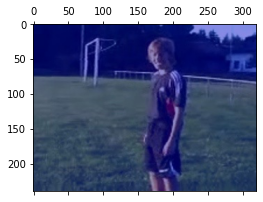

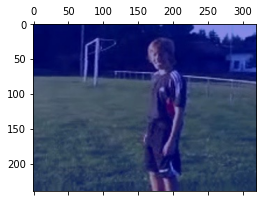

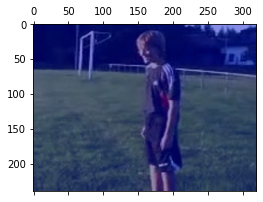

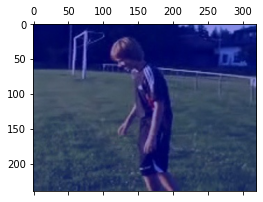

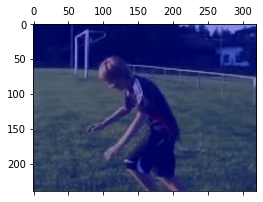

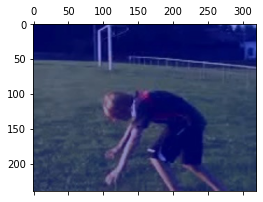

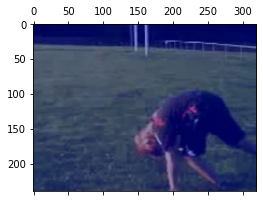

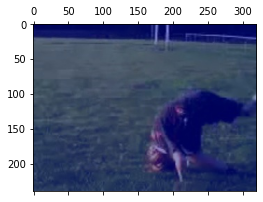

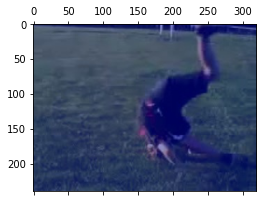

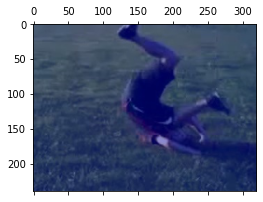

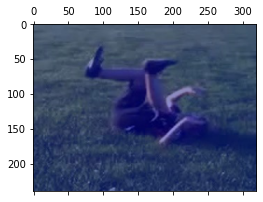

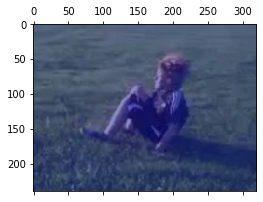

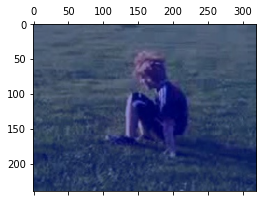

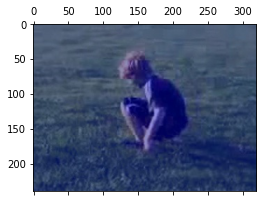

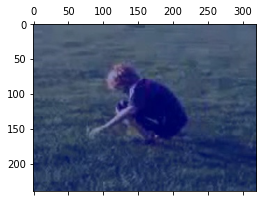

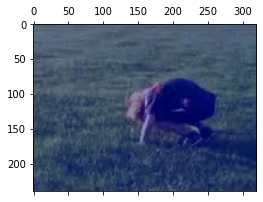

In [59]:
import cv2
# import numpy as np

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# average the channels of the activations
print(f"Frames : {num_vid_frames}")
for which_frame in range(num_vid_frames):
  # print(activations[which_frame].shape)  # [b_z,  512, 14, 14]
  heatmap = torch.mean(activations[which_frame], dim=1).squeeze(0)
  # print(heatmap.shape)  # [ 14, 14]

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap.numpy(), 0)

  # draw the heatmap
  plt.matshow(heatmap/np.max(heatmap))

  print(test_file_name[0] + '/' + str(10000 + which_frame) + '.jpg')
  img = cv2.imread(test_file_name[0] + '/' + str(10000+which_frame) + '.jpg')

  # print((img.shape[1], img.shape[0]))
  heatmap = heatmap/np.max(heatmap)
  heatmap1 = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap1 = np.uint8(255 * (heatmap1))
  heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
  superimposed_img = heatmap1 * 0.7 + img * 0.55
  cv2.imwrite('./map' + str(which_frame) + '.jpg', superimposed_img)

  img = Image.open('./map' + str(which_frame) + '.jpg')
  plt.imshow(img)

t-SNE visualisation

In [ ]:
PATH = '/content/drive/MyDrive/ADL-2/saved_model_vgg.pt'
model = Vgg19Rnn(params).to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
import pickle

model.eval()
acc = 0
labels = []
embedded_videos = []
part = 0
for i, (x,y) in enumerate(train_loader):
    # print(x.shape,y.shape)
    x = x.to(device)
    labels.extend(y.numpy().tolist())
    y = y.to(device)
    _, output = model(x)
    # print(output.shape)
    acc += torch.sum(torch.argmax(_,dim=-1) == y).item()
    output = output.detach().cpu().numpy().tolist()
    embedded_videos.extend(output)
    if len(embedded_videos) > 40:
      my_dictionary = {'x':embedded_videos,'y':labels}
      pickle.dump(my_dictionary, open('data_part_' + str(part) + '.pkl', 'wb'))
      part += 1
      embedded_videos, labels = [], []

      
    # print(stacked_vecs.shape)
print(f"Matches in {acc} out of {len(train_loader)*BATCH_SIZE}")


KeyboardInterrupt: ignored

In [ ]:
print(part)

21


In [ ]:
embedded_videos = []
labels = []

for i in range(part):
  with open('data_part_' + str(i) + '.pkl', 'rb') as handle:
    p = pickle.load(handle)
    embedded_videos.extend(p['x'])
    labels.extend(p['y'])

In [ ]:
# embedded_videos = stacked_vecs.detach().cpu().numpy().tolist()
assert len(embedded_videos) == len(labels)
len(labels)

924

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(embedded_videos)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 924 samples in 0.011s...
[t-SNE] Computed neighbors for 924 samples in 0.245s...
[t-SNE] Computed conditional probabilities for sample 924 / 924
[t-SNE] Mean sigma: 0.916472
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.554581
[t-SNE] KL divergence after 1000 iterations: 1.007721


In [ ]:
tsne_results

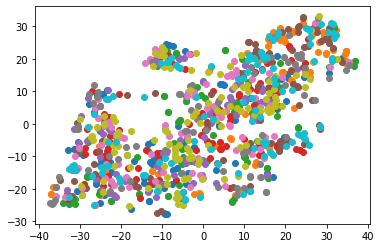

In [ ]:
for class_ in range(10):
  plt.scatter([tsne_results[i][0] for i in range(len(labels)) if labels[i] == class_],[tsne_results[i][1] for i in range(len(labels)) if labels[i] == class_])

plt.show()